In [5]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
train_df = pd.read_csv('../data/cleaned_train_with_amenities.csv', dtype={'postal_code': str})
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162691 entries, 0 to 162690
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   town                       162691 non-null  object 
 1   flat_type                  162691 non-null  object 
 2   block                      162691 non-null  object 
 3   street                     162691 non-null  object 
 4   floor_area_sqm             162691 non-null  float64
 5   flat_model                 162691 non-null  object 
 6   lease_commence_data        162691 non-null  int64  
 7   resale_price               162691 non-null  float64
 8   postal_code                162691 non-null  object 
 9   latitude                   162691 non-null  float64
 10  longitude                  162691 non-null  float64
 11  max_floor                  162691 non-null  int64  
 12  subzone                    162691 non-null  object 
 13  height                     16

In [7]:
# Remove outliers based on floor_area_sqm more than 200 sqm
train_df = train_df[train_df['floor_area_sqm'] <= 200]

                           resale_price  floor_area_sqm  max_floor    height  \
resale_price                   1.000000        0.577912   0.461117  0.342762   
floor_area_sqm                 0.577912        1.000000   0.003856 -0.015352   
max_floor                      0.461117        0.003856   1.000000  0.578028   
height                         0.342762       -0.015352   0.578028  1.000000   
index                          0.400555       -0.044627   0.025430  0.009213   
mrt_status                     0.041823       -0.080419  -0.004047  0.004084   
age_at_sale                   -0.306126       -0.107890  -0.450715 -0.270820   
flat_type_num                  0.589844        0.954280   0.069886  0.026729   
flat_model_num                 0.501135        0.495798   0.282583  0.163520   
longitude                      0.097493       -0.006472  -0.101318 -0.049501   
latitude                      -0.170855        0.162214  -0.258385 -0.144287   
mrt_distance                   0.068761 

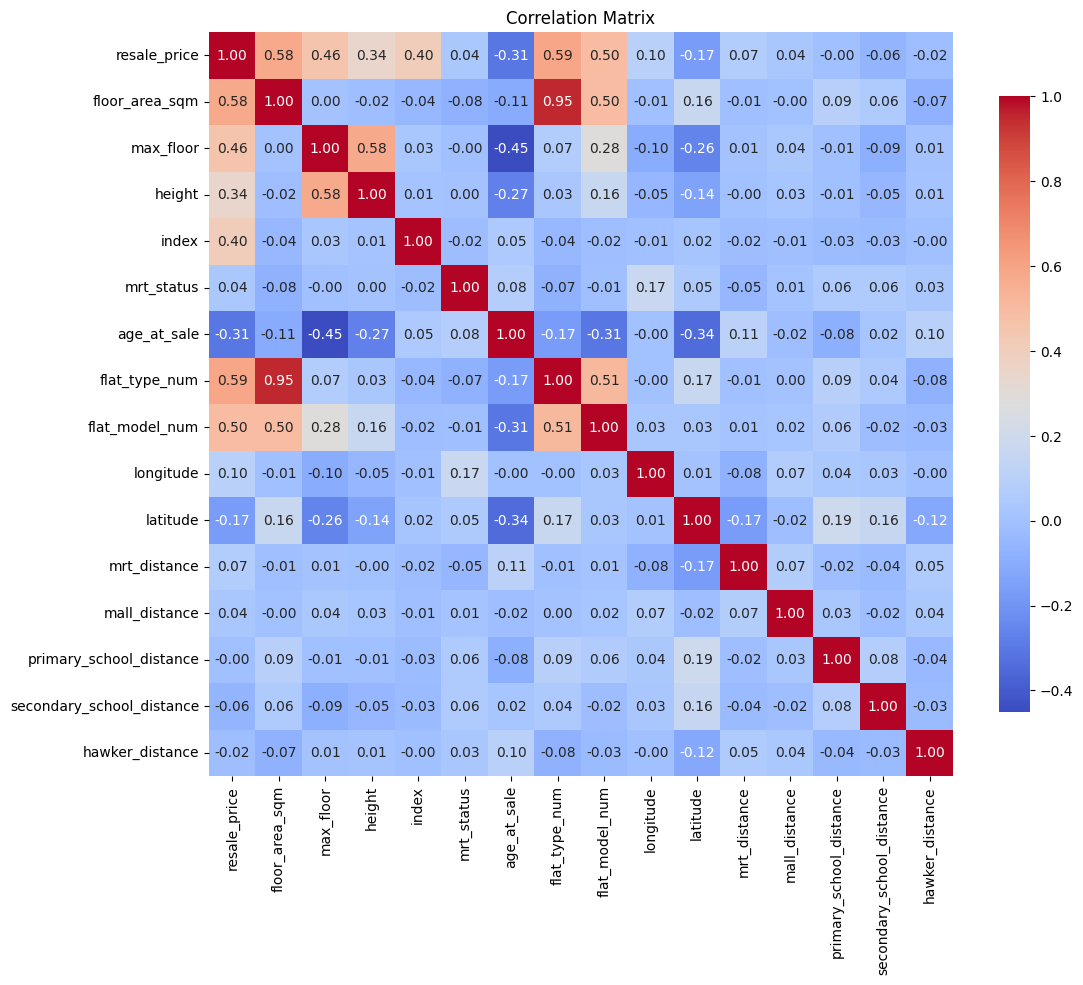

In [8]:
# print correlation matrix map for selected numerical features
selected_numeric_features = ['resale_price', 'floor_area_sqm', 'max_floor', 'height', 'index', 'mrt_status','age_at_sale','flat_type_num', 'flat_model_num','longitude','latitude']
distance_features = ['mrt_distance', 'mall_distance', 'primary_school_distance', 'secondary_school_distance', 'hawker_distance']
selected_numeric_features += distance_features
corr_matrix = train_df[selected_numeric_features].corr()
print(corr_matrix)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix")
plt.show()

In [9]:
# Select features for model
selected_categorical_features = ['subzone']
target_variable = 'resale_price'
train_df = train_df[selected_numeric_features + selected_categorical_features]
# Split the data into training and validation sets (80% train, 20% val) using random sampling
training_set, validation_set = train_test_split(train_df, test_size=0.2, random_state=42)
# separate features and target variable
X_train = training_set.drop(columns=[target_variable])
y_train = training_set[target_variable]
X_val = validation_set.drop(columns=[target_variable])
y_val = validation_set[target_variable]
# one-hot encode categorical features
X_train = pd.get_dummies(X_train, columns=selected_categorical_features, drop_first=False)
X_val = pd.get_dummies(X_val, columns=selected_categorical_features, drop_first=False)
# align X_val to have same columns as X_train
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

In [10]:
# Now try xgboost for comparison
import xgboost as xgb
xgb_model = xgb.XGBRegressor(n_estimators=600, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_val)
xgb_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'XGBoost RMSE: {xgb_rmse}')

XGBoost RMSE: 26770.79899992767


In [11]:
# Analyze feature importance
importance = xgb_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(30))

                         Feature  Importance
6                  flat_type_num    0.120425
1                      max_floor    0.075667
7                 flat_model_num    0.075472
170               subzone_yunnan    0.067973
123              subzone_sennett    0.048246
0                 floor_area_sqm    0.047664
18            subzone_anak bukit    0.041747
9                       latitude    0.036477
28           subzone_bishan east    0.026027
8                      longitude    0.023112
3                          index    0.022416
4                     mrt_status    0.020628
124    subzone_serangoon central    0.019091
144          subzone_tiong bahru    0.018561
98             subzone_marymount    0.018081
154        subzone_upper thomson    0.014479
33            subzone_brickworks    0.014361
157                subzone_wenya    0.013617
153     subzone_upper paya lebar    0.012213
97         subzone_marine parade    0.010432
78            subzone_kaki bukit    0.010214
112       

In [12]:
# try decision tree regressor
dt_model = DecisionTreeRegressor(max_depth=20, random_state=42, min_samples_split=5, min_samples_leaf=4)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_val)
dt_rmse = np.sqrt(mean_squared_error(y_val, y_pred_dt))
print(f'Decision Tree RMSE: {dt_rmse}')

Decision Tree RMSE: 38634.252127808504


In [13]:
# Analyze decision tree feature importance
dt_importance = dt_model.feature_importances_
dt_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': dt_importance})
print(dt_feature_importance_df.sort_values(by='Importance', ascending=False).head(30))

                       Feature  Importance
0               floor_area_sqm    0.384843
3                        index    0.174212
1                    max_floor    0.124178
9                     latitude    0.081842
7               flat_model_num    0.070349
8                    longitude    0.054810
5                  age_at_sale    0.035757
2                       height    0.015580
14             hawker_distance    0.011802
10                mrt_distance    0.009080
11               mall_distance    0.007792
13   secondary_school_distance    0.006220
6                flat_type_num    0.004423
12     primary_school_distance    0.002717
123            subzone_sennett    0.001540
98           subzone_marymount    0.001132
33          subzone_brickworks    0.001106
154      subzone_upper thomson    0.001037
4                   mrt_status    0.000961
28         subzone_bishan east    0.000774
44           subzone_chinatown    0.000735
148           subzone_toh guan    0.000718
153   subzo

In [14]:
# Normalize features for ridge regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [15]:
# try regression with all features
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_val)
ridge_rmse = np.sqrt(mean_squared_error(y_val, y_pred_ridge))
print(f'Ridge RMSE: {ridge_rmse}')

Ridge RMSE: 53539.73951692718


In [16]:
# Analyze coefficients of ridge regression
ridge_coefficients = ridge_model.coef_
ridge_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': ridge_coefficients})
print(ridge_feature_importance_df.sort_values(by='Importance', ascending=False).head(30))


                            Feature     Importance
10                     mrt_distance  764257.499617
11                    mall_distance  493092.340762
123                 subzone_sennett  282094.387333
18               subzone_anak bukit  199598.439884
34                    subzone_bugis  153522.395292
151                subzone_tyersall  151134.546091
98                subzone_marymount  144779.516163
28              subzone_bishan east  141917.509474
97            subzone_marine parade  135573.467742
144             subzone_tiong bahru  134480.448394
44                subzone_chinatown  132608.013662
41             subzone_changi point  130454.455083
153        subzone_upper paya lebar  125327.001989
124       subzone_serangoon central  123281.497597
20   subzone_ang mo kio town centre  122884.848582
58             subzone_everton park  115931.991626
154           subzone_upper thomson  111464.644689
54          subzone_coronation road  105052.514581
146       subzone_toa payoh cen

In [17]:
# try knn regressor for comparison
knn_model = KNeighborsRegressor(n_neighbors=4)
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_val_scaled)
knn_rmse = np.sqrt(mean_squared_error(y_val, y_pred_knn))
print(f'KNN RMSE: {knn_rmse}')


KNN RMSE: 35634.52332817729


In [18]:
# extract subzone ranking from ridge regression coefficients and map ranking to subzone names
subzone_features = [col for col in feature_names if col.startswith('subzone_')]
subzone_importance = ridge_coefficients[[feature_names.tolist().index(f) for f in subzone_features]]
subzone_ranking = pd.DataFrame({'Subzone': subzone_features, 'Importance': subzone_importance})
subzone_ranking = subzone_ranking.sort_values(by='Importance', ascending=True)
print(subzone_ranking)
# create subzone rank mapping
subzone_rank_mapping = {row['Subzone'].replace('subzone_', ''): rank+1 for rank, row in subzone_ranking.reset_index().iterrows()}
print(subzone_rank_mapping)
# remove subzone and use subzone_rank instead for modeling
train_df['subzone_rank'] = train_df['subzone'].map(subzone_rank_mapping)
# select features for model again
train1_df = train_df[selected_numeric_features + ['subzone_rank']]
# create new training and validation sets with subzone_rank
training_set, validation_set = train_test_split(train1_df, test_size=0.2, random_state=42)
X_train = training_set.drop(columns=[target_variable])
y_train = training_set[target_variable]
X_val = validation_set.drop(columns=[target_variable])
y_val = validation_set[target_variable]

                         Subzone     Importance
142                subzone_wenya -258178.896843
155               subzone_yunnan -237475.157539
62   subzone_jurong west central -206224.873042
118         subzone_taman jurong -196370.533595
124        subzone_teban gardens -190307.066565
..                           ...            ...
83             subzone_marymount  144779.516163
136             subzone_tyersall  151134.546091
19                 subzone_bugis  153522.395292
3             subzone_anak bukit  199598.439884
108              subzone_sennett  282094.387333

[156 rows x 2 columns]
{'wenya': 1, 'yunnan': 2, 'jurong west central': 3, 'taman jurong': 4, 'teban gardens': 5, 'yew tee': 6, 'peng siang': 7, 'choa chu kang north': 8, 'keat hong': 9, 'brickworks': 10, 'fajar': 11, 'gombak': 12, 'senja': 13, 'boon lay place': 14, 'saujana': 15, 'bukit batok south': 16, 'teck whye': 17, 'choa chu kang central': 18, 'hong kah': 19, 'yuhua west': 20, 'sembawang north': 21, 'bangkit': 22

In [19]:
# Now try xgboost again with subzone_rank
xgb1_model = xgb.XGBRegressor(n_estimators=600, max_depth=6, random_state=42)
xgb1_model.fit(X_train, y_train)
y_pred = xgb1_model.predict(X_val)
xgb1_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'XGBoost RMSE: {xgb1_rmse}')


XGBoost RMSE: 26665.67349990681


In [20]:
# Try decision tree regressor with subzone_rank
dt1_model = DecisionTreeRegressor(max_depth=20, random_state=42, min_samples_split=5, min_samples_leaf=4)
dt1_model.fit(X_train, y_train)
y_pred = dt1_model.predict(X_val)
dt1_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'Decision Tree RMSE: {dt1_rmse}')

Decision Tree RMSE: 37588.37310655981


In [21]:
# now scale features for KNN regression
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
# try regression with all features
knn1_model = KNeighborsRegressor(n_neighbors=5)
knn1_model.fit(X_train, y_train)
y_pred = knn1_model.predict(X_val)
knn1_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'KNN Regression RMSE: {knn1_rmse}')

KNN Regression RMSE: 34749.625412802656


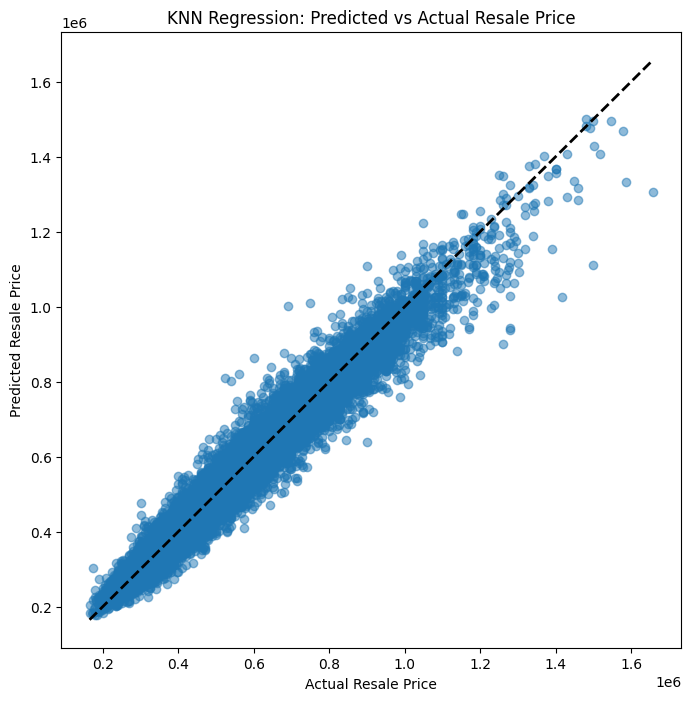

In [22]:
# plot predicted vs actual resale prices for KNN regression
plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.title('KNN Regression: Predicted vs Actual Resale Price')
plt.show()

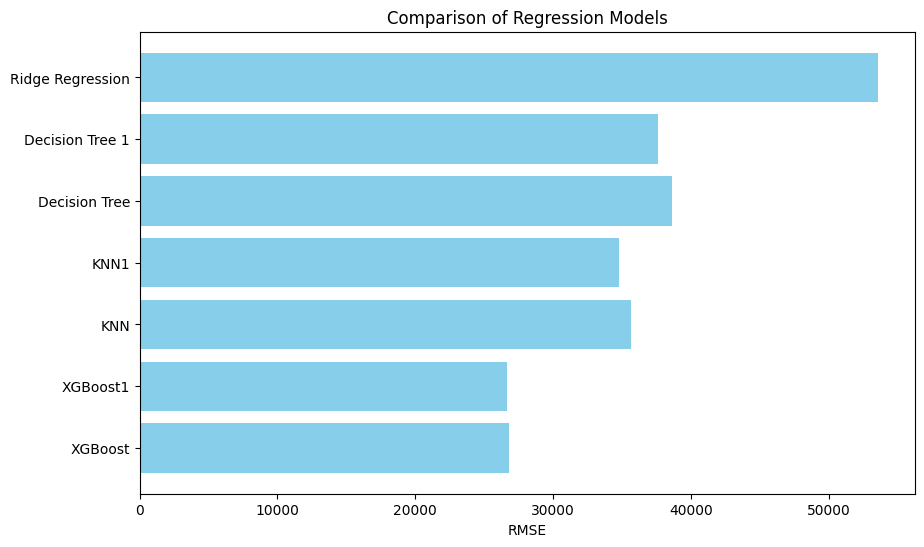

In [23]:
# plot comparison of RMSEs
models = ['XGBoost', 'XGBoost1', 'KNN','KNN1', 'Decision Tree', 'Decision Tree 1', 'Ridge Regression']
rmse_values = [xgb_rmse, xgb1_rmse, knn_rmse, knn1_rmse, dt_rmse, dt1_rmse, ridge_rmse]
plt.figure(figsize=(10, 6))
plt.barh(models, rmse_values, color='skyblue')
plt.xlabel('RMSE')
plt.title('Comparison of Regression Models')
plt.show()